In [14]:
import pm4py
import json
import pandas as pd
from tilt import tilt

In [15]:
df = pd.read_csv("tilt-enhanced-event-log.csv",quotechar="\"",index_col=0)
df = df.rename(columns={"timestamp":"time:timestamp"})
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"],format="%Y-%m-%d %H:%M:%S,%f")
df.index.name = "ident:eid"
df.reset_index(inplace=True)

In [16]:
def convert_to_sorted_list(s:str):
    if type(s) != str:return s
    l = json.loads(s.replace("\'","\""))
    if type(l)==list: l.sort()
    return l

tilt_columns = [tilt_column for tilt_column in df.columns if tilt_column.startswith("tilt:")]
for c in tilt_columns:
    df[c] = df[c].apply(convert_to_sorted_list)

In [17]:
dd_df = df[["ident:eid","concept:name"]+tilt_columns]
for c in [c for c in tilt_columns if c != "tilt:data_disclosed"]:
    dd_df[c] = dd_df[c].apply(lambda x: str(x))

/tmp/ipykernel_895006/3783271852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_df[c] = dd_df[c].apply(lambda x: str(x))


In [18]:
dd_df = dd_df.set_index(["ident:eid","concept:name"]+[c for c in tilt_columns if c != "tilt:data_disclosed"])
dd_df = dd_df.apply(lambda x: pd.Series(x).explode()).reset_index()
dd_df["id"] = dd_df[tilt_columns].apply(lambda x: hash(x.to_string()),axis=1)

In [19]:
def build_data_disclosed_element(s:pd.Series)->dict:
    legal_bases = [{"reference": i ,"description":None} for i in convert_to_sorted_list(s["tilt:legal_bases"])]
    purposes = [{"purpose": i ,"description":None} for i in convert_to_sorted_list(s["tilt:purposes"])]
    return {
        "_id":s["id"],
        "category":s["tilt:data_disclosed"],
        "legalBases":legal_bases,
        "purposes":purposes
    }


/tmp/ipykernel_895006/887907373.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_dd["tilt:element"] = unique_dd.apply(build_data_disclosed_element,axis=1)


In [20]:
df2 = pd.merge(left=dd_df,right=unique_dd[["id","tilt:element"]], on="id")

In [21]:
bpmn :pm4py.BPMN= pm4py.discover_bpmn_inductive(df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [22]:
pm4py.write_bpmn(bpmn,"tilt.bpmn")

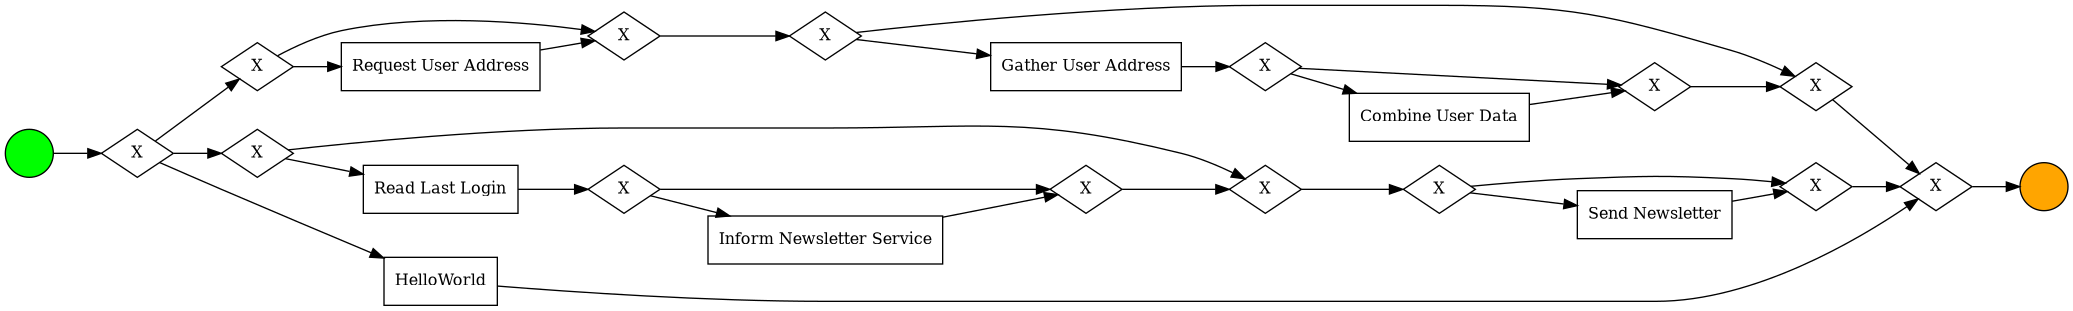

In [23]:
pm4py.view_bpmn(bpmn)

In [24]:
import xml.etree.ElementTree as ET
tree = ET.parse("tilt.bpmn")
root = tree.getroot()

In [25]:
ns = {
    "bpmn":"http://www.omg.org/spec/BPMN/20100524/MODEL",
    "tilt":"mytilturi.com"
}
ET.register_namespace("tilt","mytiltURI.com")
ET.register_namespace("bpmn","http://www.omg.org/spec/BPMN/20100524/MODEL")
ET.register_namespace("bpmndi","http://www.omg.org/spec/BPMN/20100524/DI")
ET.register_namespace("omgdc","http://www.omg.org/spec/DD/20100524/DC")
ET.register_namespace("omgdi","http://www.omg.org/spec/DD/20100524/DI")
ET.register_namespace("xsi","http://www.w3.org/2001/XMLSchema-instance")
ET.register_namespace("xsd","http://www.w3.org/2001/XMLSchema")

In [26]:
for task in root.find("bpmn:process",ns).findall("bpmn:task",ns):
    extensionElements = ET.SubElement(task,"bpmn:extensionElements")
    concept_name = task.attrib["name"]
    relevant_df = df2[df2["concept:name"]==concept_name].drop_duplicates("id")
    for id in relevant_df["id"].value_counts().index:
        elements = relevant_df[relevant_df["id"]==id]["tilt:element"].values
        if len(elements) != 0:
            dataElement = elements[0]
        else:
            continue
        dataDisclosed = ET.SubElement(extensionElements,"tilt:dataDisclosed")
        dataDisclosed.attrib["_id"] = str(id)
        dataDisclosed.attrib["category"] = dataElement["category"]
        for x in dataElement["legalBases"]:
            lb = ET.SubElement(dataDisclosed,"tilt:legalBases")
            lb.attrib["reference"] = x["reference"]
        for x in dataElement["purposes"]:
            lb = ET.SubElement(dataDisclosed,"tilt:purposes")
            lb.attrib["purpose"] = x["purpose"]

In [27]:
tree.write("output.bpmn")

In [28]:
def print_child(xml:ET.Element):
    print(xml.attrib,xml.tag)
    for child in xml:
        print_child(child)
print_child(root)

{'targetNamespace': 'http://www.signavio.com/bpmn20', 'typeLanguage': 'http://www.w3.org/2001/XMLSchema', 'expressionLanguage': 'http://www.w3.org/1999/XPath'} {http://www.omg.org/spec/BPMN/20100524/MODEL}definitions
{'id': 'id3cce9e56-615d-45de-88bb-31de2e2a4b4d', 'name': 'diagram'} {http://www.omg.org/spec/BPMN/20100524/DI}BPMNDiagram
{'bpmnElement': 'id5686ee53-70cd-4cb4-b9ea-527f4977ff0c', 'id': 'id9929a6a9-6261-40b4-b606-cf65d9fa58d4'} {http://www.omg.org/spec/BPMN/20100524/DI}BPMNPlane
{'bpmnElement': 'ide4d28beb-579f-443b-ab3a-f36c7c8ba742', 'id': 'ide4d28beb-579f-443b-ab3a-f36c7c8ba742_gui'} {http://www.omg.org/spec/BPMN/20100524/DI}BPMNShape
{'height': '60', 'width': '60', 'x': '1904', 'y': '1411'} {http://www.omg.org/spec/DD/20100524/DC}Bounds
{'bpmnElement': 'id59a7a3ef-2b48-4424-9918-c020209af6fa', 'id': 'id59a7a3ef-2b48-4424-9918-c020209af6fa_gui'} {http://www.omg.org/spec/BPMN/20100524/DI}BPMNShape
{'height': '60', 'width': '93', 'x': '1428', 'y': '2258'} {http://www.omg.